# Синхронизация с гит

In [1]:
# --- БЛОК №1: НАЧАЛО РАБОТЫ (выполнять в каждой новой сессии) ---

from google.colab import drive, userdata
import os

# 1. Монтируем Google Drive
drive.mount('/content/drive')

# 2. Получаем секретный токен
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')

# 3. Указываем ваше имя и email (как на GitHub)
GIT_USERNAME = "kirichich1" # <-- Ваше имя пользователя
GIT_EMAIL = "kirichich@bk.ru" # <-- Ваша почта

# 4. !!! ПРЕДСТАВЛЯЕМСЯ СИСТЕМЕ GIT !!!
# Эта конфигурация будет действовать до конца текущей сессии
!git config --global user.name "{GIT_USERNAME}"
!git config --global user.email "{GIT_EMAIL}"

# 5. Переходим в директорию проекта
PROJECT_PATH = "/content/drive/MyDrive/GitHub/no2_prediction_pipeline"
%cd {PROJECT_PATH}

# 6. (Рекомендуется) Скачиваем последние изменения с GitHub на случай, если вы работали с другого устройства
!git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/no2_prediction_pipeline
Already up to date.


# Импорт библиотек и загрузка данных

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
file_path = '/content/drive/MyDrive/GitHub/no2_prediction_pipeline/data/processed/Surgut_data_2019_to_2024_COMBINED_WITH_AAI.csv'

In [4]:
df = pd.read_csv(file_path)

# Начальная очистка и подготовка данных

In [5]:
# --- Начальная очистка и подготовка данных (ИСПРАВЛЕННАЯ ВЕРСИЯ) ---

# Преобразуем колонку 'date' в формат datetime для дальнейшей работы
df['date'] = pd.to_datetime(df['date'])

# Создаем целевую переменную и удаляем дубликат, если необходимо
if 'no2_umol_m2' not in df.columns:
    df['no2_umol_m2'] = df['no2_trop_mean'] * 1e6
if 'no2_trop_mean' in df.columns:
    df = df.drop('no2_trop_mean', axis=1)

# Заполняем редкие пропуски в признаках
# Важно: Сначала заполняем пропуски в исходном df
median_cloud = df['cloud_frac_mean'].median()
df['cloud_frac_mean'].fillna(median_cloud, inplace=True)

# !!! Ключевой шаг: работаем только с реальными данными NO2
### ИЗМЕНЕНИЕ ЗДЕСЬ: добавили .copy() ###
df_processed = df.dropna(subset=['no2_umol_m2']).copy()

print(f"Количество строк после удаления пропусков в NO2: {len(df_processed)}")

Количество строк после удаления пропусков в NO2: 877


/tmp/ipython-input-4112952202.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cloud_frac_mean'].fillna(median_cloud, inplace=True)


# Feature Engineering

In [6]:
# --- Feature Engineering (ВЕРСИЯ: Winter Interaction) ---

# --- ШАГ 3.1: Базовые признаки ---
print("Создание базовых признаков...")
df_processed['year'] = df_processed['date'].dt.year

# Вектор ветра
df_processed['wind_speed'] = np.sqrt(df_processed['u_wind_10m']**2 + df_processed['v_wind_10m']**2)
df_processed['wind_direction'] = (270 - np.arctan2(df_processed['v_wind_10m'], df_processed['u_wind_10m']) * 180 / np.pi) % 360

# Календарь
df_processed['month'] = df_processed['date'].dt.month
df_processed['day_of_year'] = df_processed['date'].dt.dayofyear
df_processed['day_of_week'] = df_processed['date'].dt.dayofweek
df_processed['week_of_year'] = df_processed['date'].dt.isocalendar().week.astype(int)

# --- ФИЗИЧЕСКИЕ ПРИЗНАКИ ---

# 1. HDD (Нагрузка на отопление)
df_processed['HDD'] = (18 - df_processed['temperature_celsius']).clip(lower=0)

# 2. Индекс Застоя (Stagnation)
df_processed['stagnation_index'] = df_processed['pressure_hpa'] / (df_processed['wind_speed'] + 0.1)

# 3. !!! НОВОЕ: Зимняя ловушка (Взаимодействие холода и застоя) !!!
# Чем холоднее (высокий HDD) И чем сильнее застой, тем выше этот коэффициент.
df_processed['winter_stagnation'] = df_processed['HDD'] * df_processed['stagnation_index']

# --- ШАГ 3.2: Лаги и Тренды ---
print("\nСоздание лагов и скользящих средних...")
df_processed = df_processed.sort_values(by='date')
grouped = df_processed.groupby('year')

# Лаги
df_processed['no2_lag_1'] = grouped['no2_umol_m2'].shift(1)
df_processed['wind_speed_lag_1'] = grouped['wind_speed'].shift(1)
df_processed['temperature_lag_1'] = grouped['temperature_celsius'].shift(1)
df_processed['aai_lag_1'] = grouped['aai_mean'].shift(1)

# Скользящие средние
df_processed['no2_roll_mean_3'] = grouped['no2_umol_m2'].shift(1).rolling(window=3).mean()
df_processed['no2_roll_mean_7'] = grouped['no2_umol_m2'].shift(1).rolling(window=7).mean()
df_processed['wind_roll_mean_3'] = grouped['wind_speed'].shift(1).rolling(window=3).mean()

# Delta Wind
df_processed['delta_wind'] = df_processed['wind_speed'] - df_processed['wind_speed_lag_1']

# --- ШАГ 3.3: Очистка ---
initial_rows = len(df_processed)
roll_columns = ['no2_roll_mean_3', 'no2_roll_mean_7', 'wind_roll_mean_3', 'no2_lag_1']
df_processed.dropna(subset=roll_columns, inplace=True)

print(f"Итоговое количество строк: {len(df_processed)}")

Создание базовых признаков...

Создание лагов и скользящих средних...
Итоговое количество строк: 835


# Разделение данных на обучающую и тестовую выборки

In [7]:
# Обучаемся на всех данных ДО 2024 года
train_data = df_processed[df_processed['year'] < 2024]
# Тестируем на ПОЛНОМ 2024 годе
test_data = df_processed[df_processed['year'] == 2024]

In [8]:
print(f"\nРазмер обучающей выборки (2019-2023): {len(train_data)} строк")
print(f"Размер тестовой выборки (2024): {len(test_data)} строк")


Размер обучающей выборки (2019-2023): 677 строк
Размер тестовой выборки (2024): 158 строк


# Определение признаков (X) и целевой переменной (y)

In [9]:
# --- ОПРЕДЕЛЕНИЕ ПРИЗНАКОВ (ВЕРСИЯ: Без логарифма, Без облаков, С физикой) ---
train_data = df_processed[df_processed['year'] < 2024]
test_data = df_processed[df_processed['year'] == 2024]

# ВОЗВРАЩАЕМ ОБЫЧНУЮ ЦЕЛЕВУЮ ПЕРЕМЕННУЮ
# (clip(0) оставляем на всякий случай, чтобы убрать шум, но не логарифмируем)
y_train = train_data['no2_umol_m2'].clip(lower=0)
y_test = test_data['no2_umol_m2']
dates_test = test_data['date']

features = [
    # Метеорология (БЕЗ cloud_frac_mean)
    'temperature_celsius', 'pressure_hpa',
    'wind_speed', 'wind_direction', 'aai_mean',
    'month', 'day_of_year', 'day_of_week', 'week_of_year',

    # Физика
    'HDD',
    'stagnation_index',
    'winter_stagnation',  # Оставляем, дадим шанс без логарифма
    'delta_wind',

    # Лаги и Тренды
    'no2_lag_1', 'wind_speed_lag_1', 'temperature_lag_1', 'aai_lag_1',
    'no2_roll_mean_3', 'no2_roll_mean_7', 'wind_roll_mean_3'
]

X_train = train_data[features]
X_test = test_data[features]

# Инициализация и обучение модели RandomForestRegressor

In [10]:
# --- ОБУЧЕНИЕ МОДЕЛИ ---
# Увеличиваем количество деревьев до 500 для стабильности
print(f"\nОбучение модели (n_estimators=500) на {len(features)} признаках...")
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, oob_score=True)

model.fit(X_train, y_train)
print("Модель обучена.")
print(f"OOB Score (R^2 на трейне): {model.oob_score_:.3f}")

# --- ПРЕДСКАЗАНИЕ ---
y_pred = model.predict(X_test)

# --- ОЦЕНКА ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Оценка качества (Без облаков, Без Log) ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.3f}")


Обучение модели (n_estimators=500) на 20 признаках...
Модель обучена.
OOB Score (R^2 на трейне): 0.269

--- Оценка качества (Без облаков, Без Log) ---
MAE: 11.48
RMSE: 17.93
R^2: 0.379


# Предсказание и оценка качества модели

In [11]:
# --- ПРАВИЛЬНОЕ ПРЕДСКАЗАНИЕ (БЕЗ ЭКСПОНЕНТЫ) ---

# Модель обучена на нормальных данных, поэтому предсказывает сразу нормальные данные
y_pred = model.predict(X_test)

# --- ОЦЕНКА ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Финальная оценка качества (Best Model) ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.3f}")


--- Финальная оценка качества (Best Model) ---
MAE: 11.48
RMSE: 17.93
R^2: 0.379


# Визуализация результатов

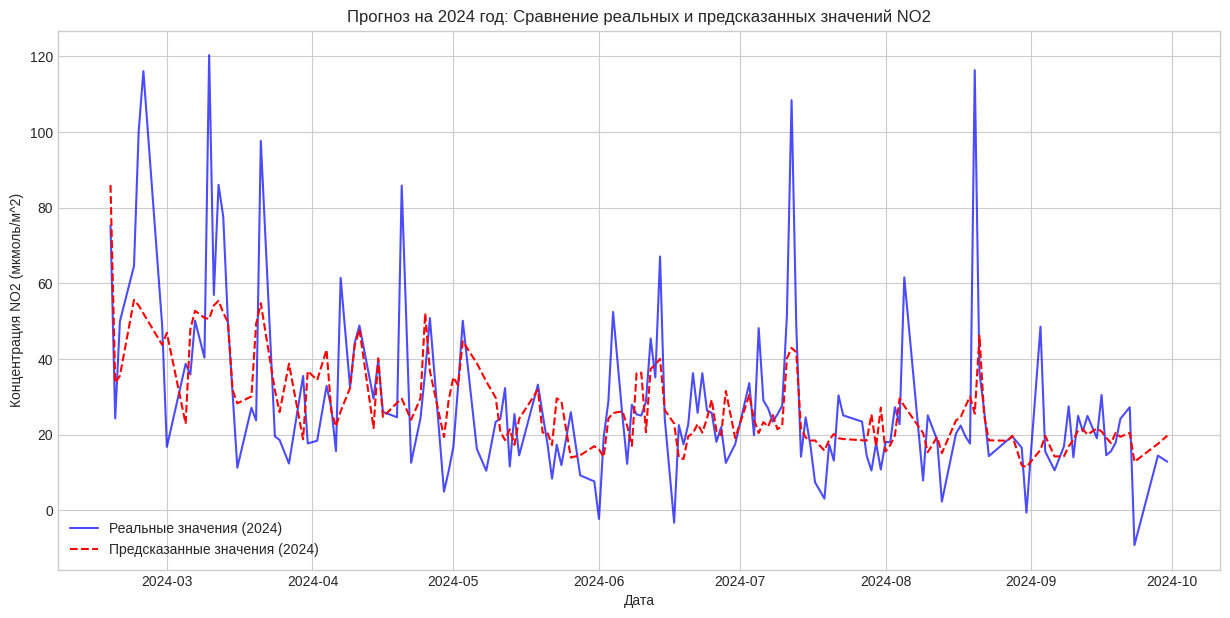

In [12]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 7))
plt.plot(dates_test, y_test.values, label='Реальные значения (2024)', color='blue', alpha=0.7)
plt.plot(dates_test, y_pred, label='Предсказанные значения (2024)', color='red', linestyle='--')
plt.title('Прогноз на 2024 год: Сравнение реальных и предсказанных значений NO2')
plt.xlabel('Дата')
plt.ylabel('Концентрация NO2 (мкмоль/м^2)')
plt.legend()
plt.show()

# Анализ важности признаков

In [13]:
feature_importances = pd.DataFrame(model.feature_importances_, index=features, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)

print("\n--- Важность признаков для модели ---")
print(feature_importances)


--- Важность признаков для модели ---
                     importance
winter_stagnation      0.133099
pressure_hpa           0.104385
stagnation_index       0.084120
wind_direction         0.063655
no2_lag_1              0.062631
no2_roll_mean_7        0.058233
no2_roll_mean_3        0.055760
temperature_lag_1      0.053903
wind_speed             0.051855
aai_lag_1              0.050425
day_of_year            0.044409
wind_roll_mean_3       0.043952
aai_mean               0.040408
wind_speed_lag_1       0.038930
delta_wind             0.032739
temperature_celsius    0.027995
HDD                    0.017560
week_of_year           0.016573
day_of_week            0.015312
month                  0.004057


# Верификация модели для научной статьи

In [38]:
start_date = '2024-08-10'
end_date = '2024-08-31'

# Фильтруем df по новому диапазону дат
filtered_df_new_range = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Выбираем нужные колонки
selected_columns_new_range = filtered_df_new_range[['date', 'pressure_hpa', 'temperature_celsius', 'no2_umol_m2']]

selected_columns_new_range

,date,pressure_hpa,temperature_celsius,no2_umol_m2
1402,2024-08-10,1002.996668,13.579558,25.076312
1403,2024-08-11,999.187357,13.564651,NaN
1404,2024-08-12,999.175918,13.640145,18.541573
1405,2024-08-13,1000.017695,15.946304,2.284526
1406,2024-08-14,992.651401,15.500183,NaN
1407,2024-08-15,992.386559,15.286912,NaN
1408,2024-08-16,991.905560,15.372191,20.229785
1409,2024-08-17,992.681094,16.521657,22.391798
1410,2024-08-18,994.470266,15.919426,19.557214
1411,2024-08-19,997.126834,16.016310,17.608040


# Зимний сезон (две близкие даты)

In [47]:
# --- БЛОК: ТОЧЕЧНАЯ ВЕРИФИКАЦИЯ (АПРЕЛЬСКИЙ КЕЙС) ---

# Даты, которые мы хотим проверить
target_dates = ['2024-04-11', '2024-04-16']

print("=== ДЕТАЛЬНЫЙ РАЗБОР ПРОГНОЗА (Зимний сезон) ===\n")

for i, date_str in enumerate(target_dates):
    # Ищем индекс этой даты в тестовой выборке
    indices = np.where(dates_test.astype(str) == date_str)[0]

    if len(indices) > 0:
        idx = indices[0] # Берем первый найденный индекс

        # Достаем данные
        actual = y_test.iloc[idx]
        pred = y_pred[idx]
        features = X_test.iloc[idx]

        # ===== РЕДАКТИРУЙТЕ ЭТОТ БЛОК ДЛЯ КАЖДОЙ ДАТЫ =====
        # Используйте i для различения дат (0 - первая дата, 1 - вторая дата)

        if i == 0:  # Первая дата: 2024-04-11
            print(f"📅 ДАТА: {date_str}")
            print(f"--------------------------------------------------")
            print(f"🔵 Реальный NO2:   {actual:.2f} мкмоль/м²")
            print(f"🔴 Прогноз модели: {pred:.2f} мкмоль/м²")
            print(f"📉 Ошибка (MAE):   {abs(actual - pred):.2f}")
            print(f"--------------------------------------------------")
            print("Физические факторы:")
            print(f"1. Температура:      {features['temperature_celsius']:.1f} °C (-13.45 °C)")
            print(f"2. Ветер:            {features['wind_speed']:.1f} м/с (2.37 м/с)")
            print(f"3. Давление:         {features['pressure_hpa']:.0f} гПа (1020 гПа)")
            print(f"4. Winter Stagnation:{features['winter_stagnation']:.2f}")
            print(f"5. Индекс Застоя:    {features['stagnation_index']:.2f}")

        elif i == 1:  # Вторая дата: 2024-04-16
            print(f"📅 ДАТА: {date_str}")
            print(f"--------------------------------------------------")
            print(f"🔵 Реальный NO2:   {actual:.2f} мкмоль/м²")
            print(f"🔴 Прогноз модели: {pred:.2f} мкмоль/м²")
            print(f"📉 Ошибка (MAE):   {abs(actual - pred):.2f}")
            print(f"--------------------------------------------------")
            print("Физические факторы:")
            print(f"1. Температура:      {features['temperature_celsius']:.1f} °C (0.9 °C)")
            print(f"2. Ветер:            {features['wind_speed']:.1f} м/с (4.9 м/с)")
            print(f"3. Давление:         {features['pressure_hpa']:.0f} гПа (1012 гПа)")
            print(f"4. Winter Stagnation:{features['winter_stagnation']:.2f}")
            print(f"5. Индекс Застоя:    {features['stagnation_index']:.2f}")

        print("\n" + "="*50 + "\n")
    else:
        print(f"Дата {date_str} не найдена в тестовой выборке 2024 года.\n")

=== ДЕТАЛЬНЫЙ РАЗБОР ПРОГНОЗА (Зимний сезон) ===

📅 ДАТА: 2024-04-11
--------------------------------------------------
🔵 Реальный NO2:   48.83 мкмоль/м²
🔴 Прогноз модели: 47.83 мкмоль/м²
📉 Ошибка (MAE):   1.00
--------------------------------------------------
Физические факторы:
1. Температура:      -13.8 °C (-13.45 °C)
2. Ветер:            2.2 м/с (2.37 м/с)
3. Давление:         1017 гПа (1020 гПа)
4. Winter Stagnation:13971.58
5. Индекс Застоя:    439.41


📅 ДАТА: 2024-04-16
--------------------------------------------------
🔵 Реальный NO2:   26.00 мкмоль/м²
🔴 Прогноз модели: 24.68 мкмоль/м²
📉 Ошибка (MAE):   1.32
--------------------------------------------------
Физические факторы:
1. Температура:      -1.1 °C (0.9 °C)
2. Ветер:            5.4 м/с (4.9 м/с)
3. Давление:         1010 гПа (1012 гПа)
4. Winter Stagnation:3478.58
5. Индекс Застоя:    182.45




# Летний сезон (две близкие даты)

In [48]:
# --- БЛОК: ТОЧЕЧНАЯ ВЕРИФИКАЦИЯ (АПРЕЛЬСКИЙ КЕЙС) ---

# Даты, которые мы хотим проверить
target_dates = ['2024-08-20', '2024-08-30']

print("=== ДЕТАЛЬНЫЙ РАЗБОР ПРОГНОЗА (Летний сезон) ===\n")

for i, date_str in enumerate(target_dates):
    # Ищем индекс этой даты в тестовой выборке
    indices = np.where(dates_test.astype(str) == date_str)[0]

    if len(indices) > 0:
        idx = indices[0] # Берем первый найденный индекс

        # Достаем данные
        actual = y_test.iloc[idx]
        pred = y_pred[idx]
        features = X_test.iloc[idx]

        # ===== РЕДАКТИРУЙТЕ ЭТОТ БЛОК ДЛЯ КАЖДОЙ ДАТЫ =====
        # Используйте i для различения дат (0 - первая дата, 1 - вторая дата)

        if i == 0:  # Первая дата: 2024-08-20
            print(f"📅 ДАТА: {date_str}")
            print(f"--------------------------------------------------")
            print(f"🔵 Реальный NO2:   {actual:.2f} мкмоль/м²")
            print(f"🔴 Прогноз модели: {pred:.2f} мкмоль/м²")
            print(f"📉 Ошибка (MAE):   {abs(actual - pred):.2f}")
            print(f"--------------------------------------------------")
            print("Физические факторы:")
            print(f"1. Температура:      {features['temperature_celsius']:.1f} °C (15.8 °C)")
            print(f"2. Ветер:            {features['wind_speed']:.1f} м/с (1.25 м/с)")
            print(f"3. Давление:         {features['pressure_hpa']:.0f} гПа (1000 гПа)")
            print(f"4. Winter Stagnation:{features['winter_stagnation']:.2f}")
            print(f"5. Индекс Застоя:    {features['stagnation_index']:.2f}")

        elif i == 1:  # Вторая дата: 2024-08-30
            print(f"📅 ДАТА: {date_str}")
            print(f"--------------------------------------------------")
            print(f"🔵 Реальный NO2:   {actual:.2f} мкмоль/м²")
            print(f"🔴 Прогноз модели: {pred:.2f} мкмоль/м²")
            print(f"📉 Ошибка (MAE):   {abs(actual - pred):.2f}")
            print(f"--------------------------------------------------")
            print("Физические факторы:")
            print(f"1. Температура:      {features['temperature_celsius']:.1f} °C (11.2 °C)")
            print(f"2. Ветер:            {features['wind_speed']:.1f} м/с (4.75 м/с)")
            print(f"3. Давление:         {features['pressure_hpa']:.0f} гПа (1006 гПа)")
            print(f"4. Winter Stagnation:{features['winter_stagnation']:.2f}")
            print(f"5. Индекс Застоя:    {features['stagnation_index']:.2f}")

        print("\n" + "="*50 + "\n")
    else:
        print(f"Дата {date_str} не найдена в тестовой выборке 2024 года.\n")

=== ДЕТАЛЬНЫЙ РАЗБОР ПРОГНОЗА (Летний сезон) ===

📅 ДАТА: 2024-08-20
--------------------------------------------------
🔵 Реальный NO2:   116.34 мкмоль/м²
🔴 Прогноз модели: 25.54 мкмоль/м²
📉 Ошибка (MAE):   90.80
--------------------------------------------------
Физические факторы:
1. Температура:      16.0 °C (15.8 °C)
2. Ветер:            1.0 м/с (1.25 м/с)
3. Давление:         999 гПа (1000 гПа)
4. Winter Stagnation:1870.96
5. Индекс Застоя:    930.58


📅 ДАТА: 2024-08-30
--------------------------------------------------
🔵 Реальный NO2:   16.55 мкмоль/м²
🔴 Прогноз модели: 11.89 мкмоль/м²
📉 Ошибка (MAE):   4.67
--------------------------------------------------
Физические факторы:
1. Температура:      11.6 °C (11.2 °C)
2. Ветер:            3.8 м/с (4.75 м/с)
3. Давление:         1007 гПа (1006 гПа)
4. Winter Stagnation:1684.30
5. Индекс Застоя:    261.36




# Коммит для гит

In [14]:
# --- БЛОК №2: СОХРАНЕНИЕ РЕЗУЛЬТАТОВ (в конце работы) ---

# 1. Проверяем статус (опционально)
!git status

# 2. ДОБАВЛЯЕМ файлы в "коробку" для отправки. Это то, что вы пропустили.
!git add .

# 3. ПОДПИСЫВАЕМ "коробку" (делаем коммит)
!git commit -m "Add verification-code for   "

# 4. ОТПРАВЛЯЕМ "коробку" на GitHub
!git push